<a href="https://colab.research.google.com/github/nickteim/Reinforcement_Learning-/blob/main/VideoTransform_MiDaS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [2]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io


# Upload video

In [ ]:
# !pip install pytube3

In [10]:
!pip install git+https://github.com/nficano/pytube

  Cloning https://github.com/nficano/pytube to /tmp/pip-req-build-4ytovl50
  Running command git clone -q https://github.com/nficano/pytube /tmp/pip-req-build-4ytovl50
  Created wheel for pytube: filename=pytube-9.7.0-cp36-none-any.whl size=40388 sha256=aec77e1b95e399bdf7200db8c44298874bd7df4ce00663833dfc25d3fee1c214
  Stored in directory: /tmp/pip-ephem-wheel-cache-7eqw3u8x/wheels/44/da/40/3b5e03abe33a91895343814fb44b309512375408f4a909555b
Successfully built pytube


In [11]:
from pytube import YouTube
from moviepy.editor import *
 
# download a file from youtube
youtube_link = 'https://www.youtube.com/watch?v=92U11ya1xuQ'
w = YouTube(youtube_link).streams.first()
w.download(output_path="/content/")

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1302528/45929032 bytes (2.8%)3915776/45929032 bytes (8.5%)7725056/45929032 bytes (16.8%)11812864/45929032 bytes (25.7%)16031744/45929032 bytes (34.9%)20152320/45929032 bytes (43.9%)24330240/45929032 bytes (53.0%)28459008/45929032 bytes (62.0%)32612352/45929032 bytes (71.0%)36765696/45929032 bytes (80.0%)40919040/45929032 bytes (89.1%)44859392/45929032 bytes (97.7%)4

'/content/28 WAYS TO PEEL AND CUT FRUITS LIKE A PRO.mp4'

In [12]:
Location_video='/content/28 WAYS TO PEEL AND CUT FRUITS LIKE A PRO.mp4'

##Proces video

###Split video to images

In [14]:
## I just did about 6000 images
os.mkdir('/content/test_vid/')
os.mkdir('/content/test_vid/Frames/')
# converting video into frames
vidcap = cv2.VideoCapture(Location_video)
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/test_vid/Frames/%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame:%d, ',count, success)
  count += 1

Streaming output truncated to the last 5000 lines.
Read a new frame:%d,  1439 True
Read a new frame:%d,  1440 True
Read a new frame:%d,  1441 True
Read a new frame:%d,  1442 True
Read a new frame:%d,  1443 True
Read a new frame:%d,  1444 True
Read a new frame:%d,  1445 True
Read a new frame:%d,  1446 True
Read a new frame:%d,  1447 True
Read a new frame:%d,  1448 True
Read a new frame:%d,  1449 True
Read a new frame:%d,  1450 True
Read a new frame:%d,  1451 True
Read a new frame:%d,  1452 True
Read a new frame:%d,  1453 True
Read a new frame:%d,  1454 True
Read a new frame:%d,  1455 True
Read a new frame:%d,  1456 True
Read a new frame:%d,  1457 True
Read a new frame:%d,  1458 True
Read a new frame:%d,  1459 True
Read a new frame:%d,  1460 True
Read a new frame:%d,  1461 True
Read a new frame:%d,  1462 True
Read a new frame:%d,  1463 True
Read a new frame:%d,  1464 True
Read a new frame:%d,  1465 True
Read a new frame:%d,  1466 True
Read a new frame:%d,  1467 True
Read a new frame:%d, 

KeyboardInterrupt: ignored

In [15]:
##zero padding every image name in folder to get the right order
import shutil
import os

sourcedir = "/content/test_vid/Frames"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

###Get model from github

 github model --> https://pytorch.org/hub/intelisl_midas_v2/

In [16]:
os.mkdir('/content/test_vid/new_model')

In [4]:
#Running it on a GPU
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/facebookresearch/WSL-Images/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-f6b98070.pt" to /root/.cache/torch/hub/checkpoints/model-f6b98070.pt


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
# filename= '/content/test_vid/Frames/0000.jpg'

### Proces images

In [17]:
def setter_inew_model():
  path1_depth = '/content/test_vid/Frames'
  data_depth = os.listdir(path1_depth)
  ordedered_list = sorted(data_depth)
  ordedered_list = ordedered_list


In [18]:
path1_depth = '/content/test_vid/Frames'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
ordedered_list = ordedered_list[1500:]

# count = 0
def images(number):
  for e in ordedered_list[:1]:
    c = e
    input = '/content/test_vid/Frames/'+c
    print(input)
    img_ori = io.imread(input)
    # # print(input)(imgUMat),
    img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()
      
    output = prediction.cpu().numpy()
    plt.imshow(output)
    plt.axis('off')
    # number = 'f0' +'1'+ '.png'
    out = "/content/food%d.png" % number
    plt.savefig(out, bbox_inches='tight')
   

    



In [19]:
def move_image_new_model(number):  
  for e in ordedered_list[:1]:
    out = "/content/food%d.png" % number
    
    im = Image.open(out)
    im.mode
    'P'
    im = im.convert('RGB')
    im.mode
    'RGB'
    out1 = "/content/test_vid/new_model/%d.jpg" % number
    im.save(out1, quality=95)
    os.remove(out)

In [20]:
path1_depth = '/content/test_vid/Frames'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
# ordedered_list =


# path1_depth2 = '/content'
# data_depth2 = os.listdir(path1_depth2)
# ordedered_list2 = sorted(data_depth2)
# print(ordedered_list2[5])

def remove(number):
  for i in  ordedered_list[:1]:
    from_folder = '/content/test_vid/Frames/' + i
    print("Removed: ", from_folder)
    os.remove(from_folder)
    
  # for e in ordedered_list2[:1]:
  #   from_folder2 = '/content/' + i
  #   print("Removed: ", from_folder2)
  #   os.remove(from_folder2)

/content/test_vid/Frames/1500.jpg
Removed:  /content/test_vid/Frames/1500.jpg
/content/test_vid/Frames/1501.jpg
Removed:  /content/test_vid/Frames/1501.jpg
/content/test_vid/Frames/1502.jpg
Removed:  /content/test_vid/Frames/1502.jpg
/content/test_vid/Frames/1503.jpg
Removed:  /content/test_vid/Frames/1503.jpg
/content/test_vid/Frames/1504.jpg
Removed:  /content/test_vid/Frames/1504.jpg
/content/test_vid/Frames/1505.jpg
Removed:  /content/test_vid/Frames/1505.jpg
/content/test_vid/Frames/1506.jpg
Removed:  /content/test_vid/Frames/1506.jpg
/content/test_vid/Frames/1507.jpg
Removed:  /content/test_vid/Frames/1507.jpg
/content/test_vid/Frames/1508.jpg
Removed:  /content/test_vid/Frames/1508.jpg
/content/test_vid/Frames/1509.jpg
Removed:  /content/test_vid/Frames/1509.jpg
/content/test_vid/Frames/1510.jpg
Removed:  /content/test_vid/Frames/1510.jpg
/content/test_vid/Frames/1511.jpg
Removed:  /content/test_vid/Frames/1511.jpg
/content/test_vid/Frames/1512.jpg
Removed:  /content/test_vid/Fr

KeyboardInterrupt: ignored

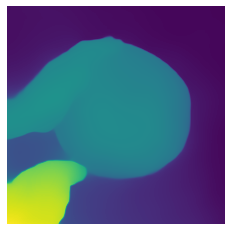

In [21]:
number=0

# for i in range(1):
for i in range(1000):
  
  setter_inew_model()

  
  path1_depth = '/content/test_vid/Frames'
  data_depth = os.listdir(path1_depth)
  ordedered_list = sorted(data_depth)
  ordedered_list = ordedered_list[1500:]

  # count = 0

  for e in ordedered_list[:1]:
    c = e
    input = '/content/test_vid/Frames/'+c
    print(input)
    img_ori = io.imread(input)
    # # print(input)(imgUMat),
    img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()
      
    output = prediction.cpu().numpy()
    plt.imshow(output)
    plt.axis('off')
    # number = 'f0' +'1'+ '.png'
    out = "/content/food%d.png" % number
    plt.savefig(out, bbox_inches='tight')
      

      
    
  move_image_new_model(number)
  remove(number)
  number += 1

  # for i in range(1):
  #  

  # for i in range(1):
    # 

   


In [23]:
#zero padding 
import shutil
import os

sourcedir = "/content/test_vid/new_model"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

##Converting it back to a video

In [24]:
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    #files.sort(key = lambda x: int(x[5:-4]))
    files = sorted(files)
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [26]:
pathIn= '/content/test_vid/new_model/'
pathOut = '/content/video1.mp4'
#enter the correct frame rates
fps = 30
convert_frames_to_video(pathIn, pathOut, fps)

/content/test_vid/new_model/00.jpg
/content/test_vid/new_model/01.jpg
/content/test_vid/new_model/02.jpg
/content/test_vid/new_model/03.jpg
/content/test_vid/new_model/04.jpg
/content/test_vid/new_model/05.jpg
/content/test_vid/new_model/06.jpg
/content/test_vid/new_model/07.jpg
/content/test_vid/new_model/08.jpg
/content/test_vid/new_model/09.jpg
/content/test_vid/new_model/10.jpg
/content/test_vid/new_model/11.jpg
/content/test_vid/new_model/12.jpg
/content/test_vid/new_model/13.jpg
/content/test_vid/new_model/14.jpg
/content/test_vid/new_model/15.jpg
/content/test_vid/new_model/16.jpg
/content/test_vid/new_model/17.jpg
/content/test_vid/new_model/18.jpg
/content/test_vid/new_model/19.jpg
/content/test_vid/new_model/20.jpg
/content/test_vid/new_model/21.jpg
/content/test_vid/new_model/22.jpg
/content/test_vid/new_model/23.jpg
/content/test_vid/new_model/24.jpg
/content/test_vid/new_model/25.jpg
/content/test_vid/new_model/26.jpg
/content/test_vid/new_model/27.jpg
/content/test_vid/ne

### Download video

In [ ]:
assert False

In [ ]:
#Downloading video
from google.colab import files
files.download('/content/video1.mp4') 